<a href="https://colab.research.google.com/github/safaiat/CT_EXP/blob/main/pytorch_recon/Torch_MLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import jax.numpy as jnp
import mbirjax
import time
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)  # Ensure GPU is correctly assigned
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Define parameters
num_views = 64
num_det_rows = 40
num_det_channels = 128
geometry_type = "parallel"

# Generate angles
angles = jnp.linspace(-np.pi / 2, np.pi / 2, num_views, endpoint=False)

# Initialize CT Model
if geometry_type == "parallel":
    ct_model = mbirjax.ParallelBeamModel((num_views, num_det_rows, num_det_channels), angles)
else:
    raise ValueError("Invalid geometry type. Expected parallel.")

# Generate & Save 3D Phantom
phantom = ct_model.gen_modified_3d_sl_phantom()
phantom = np.array(phantom)
np.save("phantom.npy", phantom)

# Load phantom and move to device
phantom_np = np.load("phantom.npy")
phantom = torch.tensor(phantom_np, dtype=torch.float32, device=device)


Available GPU memory = 11.056GB.
Estimated memory required = 0.183GB full, 0.167GB update
Using cuda:0 for main memory, cuda:0 as worker.
views_per_batch = 256; pixels_per_batch = 2048


In [ ]:

def sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles):
    """Perform forward projection in batches."""
    max_views = 16
    max_pixels = 4000

    num_views = len(angles)
    view_batch_indices = torch.arange(0, num_views, step=max_views, device=device)
    view_batch_indices = torch.cat([view_batch_indices, torch.tensor([num_views], dtype=torch.int32, device=device)])

    num_pixels = len(indices)
    pixel_batch_indices = torch.arange(0, num_pixels, step=max_pixels, device=device)
    pixel_batch_indices = torch.cat([pixel_batch_indices, torch.tensor([num_pixels], dtype=torch.int32, device=device)])

    sinogram = []

    for j, view_index_start in enumerate(view_batch_indices[:-1]):
        view_index_end = view_batch_indices[j+1]
        cur_view_batch = torch.zeros((view_index_end-view_index_start, sinogram_shape[1], sinogram_shape[2]), device=device)
        cur_view_params_batch = angles[view_index_start:view_index_end]

        print(f"Processing view batch {j+1} of {len(view_batch_indices)-1}")

        for k, pixel_index_start in enumerate(pixel_batch_indices[:-1]):
            pixel_index_end = pixel_batch_indices[k+1]
            cur_voxel_batch = voxel_values[pixel_index_start:pixel_index_end].to(device)
            cur_index_batch = indices[pixel_index_start:pixel_index_end].to(device)

            def forward_project_pixel_batch_local(view, angle):
                return forward_project_pixel_batch_to_one_view(cur_voxel_batch, cur_index_batch, angle, view,
                                                               sinogram_shape, recon_shape)

            view_map = torch.vmap(forward_project_pixel_batch_local)
            cur_view_batch = view_map(cur_view_batch, cur_view_params_batch)

        sinogram.append(cur_view_batch)

    return torch.cat(sinogram)

def forward_project_pixel_batch_to_one_view(voxel_values, pixel_indices, angle, sinogram_view, sinogram_shape, recon_shape):
    """Apply a parallel beam transformation."""
    num_views, num_det_rows, num_det_channels = sinogram_shape
    delta_voxel = 1

    # Compute projection geometry
    n_p, n_p_center, W_p_c, cos_alpha_p_xy = compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape)
    L_max = torch.clip(W_p_c, None, 1)

    for n_offset in range(-1, 2):  # Iterate over PSF radius
        n = n_p_center + n_offset
        abs_delta_p_c_n = torch.abs(n_p - n)

        # Use torch.minimum for element-wise max value
        L_p_c_n = torch.minimum(torch.clamp((W_p_c + 1) / 2 - abs_delta_p_c_n, min=0), L_max)

        # Compute projection weight
        A_chan_n = delta_voxel * L_p_c_n / cos_alpha_p_xy
        A_chan_n *= (n >= 0) * (n < num_det_channels)
        n = torch.clamp(n, 0, num_det_channels - 1)

        # Replace scatter_add_ with a differentiable approach
        indices = n.expand(num_det_rows, -1).long()
        sinogram_update = torch.zeros_like(sinogram_view)  # Create a temporary tensor
        sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))

        sinogram_view = sinogram_view + sinogram_update  # Avoid in-place operation

    return sinogram_view


In [ ]:
# Set sinogram shape
sinogram_shape = (num_views, num_det_rows, num_det_channels)
recon_shape = (num_det_channels, num_det_channels, num_det_rows)

# Angles
angles = torch.linspace(0, torch.pi, steps=num_views, device=device)

# Generate pixel indices
indices = torch.arange(recon_shape[0] * recon_shape[1], dtype=torch.int32, device=device)
voxel_values = phantom.reshape((-1,) + recon_shape[2:])[indices]

# Execute forward projection
print("Starting forward projection...")
t0 = time.time()
sinogram = sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles)
print("Elapsed time:", time.time() - t0)
print(f"Sinogram shape: {sinogram.shape}")

# Save sinogram
np.savez("sinogram_data.npz", sinogram=sinogram.cpu().numpy(), angles=angles.cpu().numpy())


Starting forward projection...
Processing view batch 1 of 4
Processing view batch 2 of 4
Processing view batch 3 of 4
Processing view batch 4 of 4
Elapsed time: 0.06990551948547363
Sinogram shape: torch.Size([64, 40, 128])


<ipython-input-36-597d39367858>:63: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::scatter_add_. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))


In [ ]:
# Load sinogram data
data = np.load("sinogram_data.npz")
y = torch.tensor(data["sinogram"], dtype=torch.float32)
angles = torch.tensor(data["angles"], dtype=torch.float32)

# Move data to the same device as before
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y = y.to(device)
angles = angles.to(device)

# Get dimensions from sinogram
num_views, num_det_rows, num_det_channels = y.shape
sinogram_shape = (num_views, num_det_rows, num_det_channels)
recon_shape = (num_det_channels, num_det_channels, num_det_rows)  # Assuming cubic reconstruction

print("Sinogram loaded successfully.")


Sinogram loaded successfully.


In [ ]:
x_init = torch.zeros(recon_shape, dtype=torch.float32, requires_grad=True, device=device)


In [ ]:
def loss_fn(x):
    """Compute MBIR loss function."""
    Ax = sparse_forward_project(
        x.reshape(-1, recon_shape[2]),
        torch.arange(x.numel() // recon_shape[2], dtype=torch.int32, device=device),
        sinogram_shape, recon_shape, angles
    )

    M = y.numel()  # Total number of elements in y
    return torch.sum((y - Ax) ** 2) / M  # Compute normalized loss


In [ ]:
# Use Adam optimizer (faster than SGD)
optimizer = optim.Adam([x_init], lr=1)

# Number of iterations
num_iterations = 2000

# Run MBIR optimization loop
print("Starting MBIR Reconstruction...")
for i in range(num_iterations):
    print(f"Iteration {i+1}/{num_iterations}")
    optimizer.zero_grad()  # Reset gradients
    loss = loss_fn(x_init)  # Compute loss
    loss.backward()  # Backpropagate gradients
    optimizer.step()  # Update reconstruction

    if i % 50 == 0:  # Print every 50 iterations
        print(f"Iteration {i}: Loss = {loss.item():.6f}")

print("Reconstruction completed.")


Starting MBIR Reconstruction...
Iteration 1/2000
Processing view batch 1 of 4
Processing view batch 2 of 4
Processing view batch 3 of 4
Processing view batch 4 of 4


<ipython-input-36-597d39367858>:63: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::scatter_add_. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))


Streaming output truncated to the last 5000 lines.
Iteration 1005/2000
Processing view batch 1 of 4
Processing view batch 2 of 4
Processing view batch 3 of 4
Processing view batch 4 of 4
Iteration 1006/2000
Processing view batch 1 of 4
Processing view batch 2 of 4
Processing view batch 3 of 4
Processing view batch 4 of 4
Iteration 1007/2000
Processing view batch 1 of 4
Processing view batch 2 of 4
Processing view batch 3 of 4
Processing view batch 4 of 4
Iteration 1008/2000
Processing view batch 1 of 4
Processing view batch 2 of 4
Processing view batch 3 of 4
Processing view batch 4 of 4
Iteration 1009/2000
Processing view batch 1 of 4
Processing view batch 2 of 4
Processing view batch 3 of 4
Processing view batch 4 of 4
Iteration 1010/2000
Processing view batch 1 of 4
Processing view batch 2 of 4
Processing view batch 3 of 4
Processing view batch 4 of 4
Iteration 1011/2000
Processing view batch 1 of 4
Processing view batch 2 of 4
Processing view batch 3 of 4
Processing view batch 4 of

In [ ]:
np.save("mbir_reconstruction.npy", x_init.detach().cpu().numpy())
print("Reconstructed image saved as 'mbir_reconstruction.npy'.")



Reconstructed image saved as 'mbir_reconstruction.npy'.


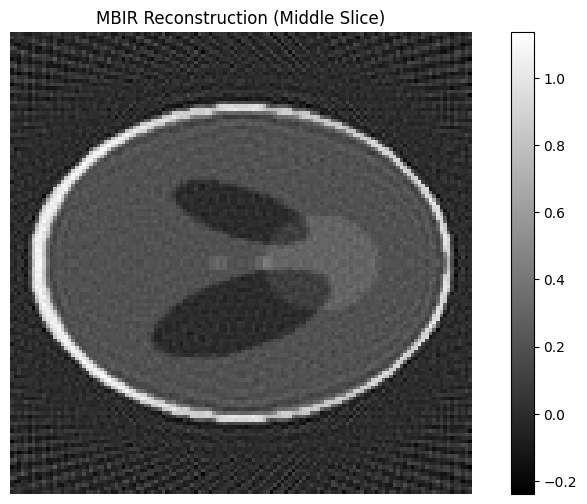

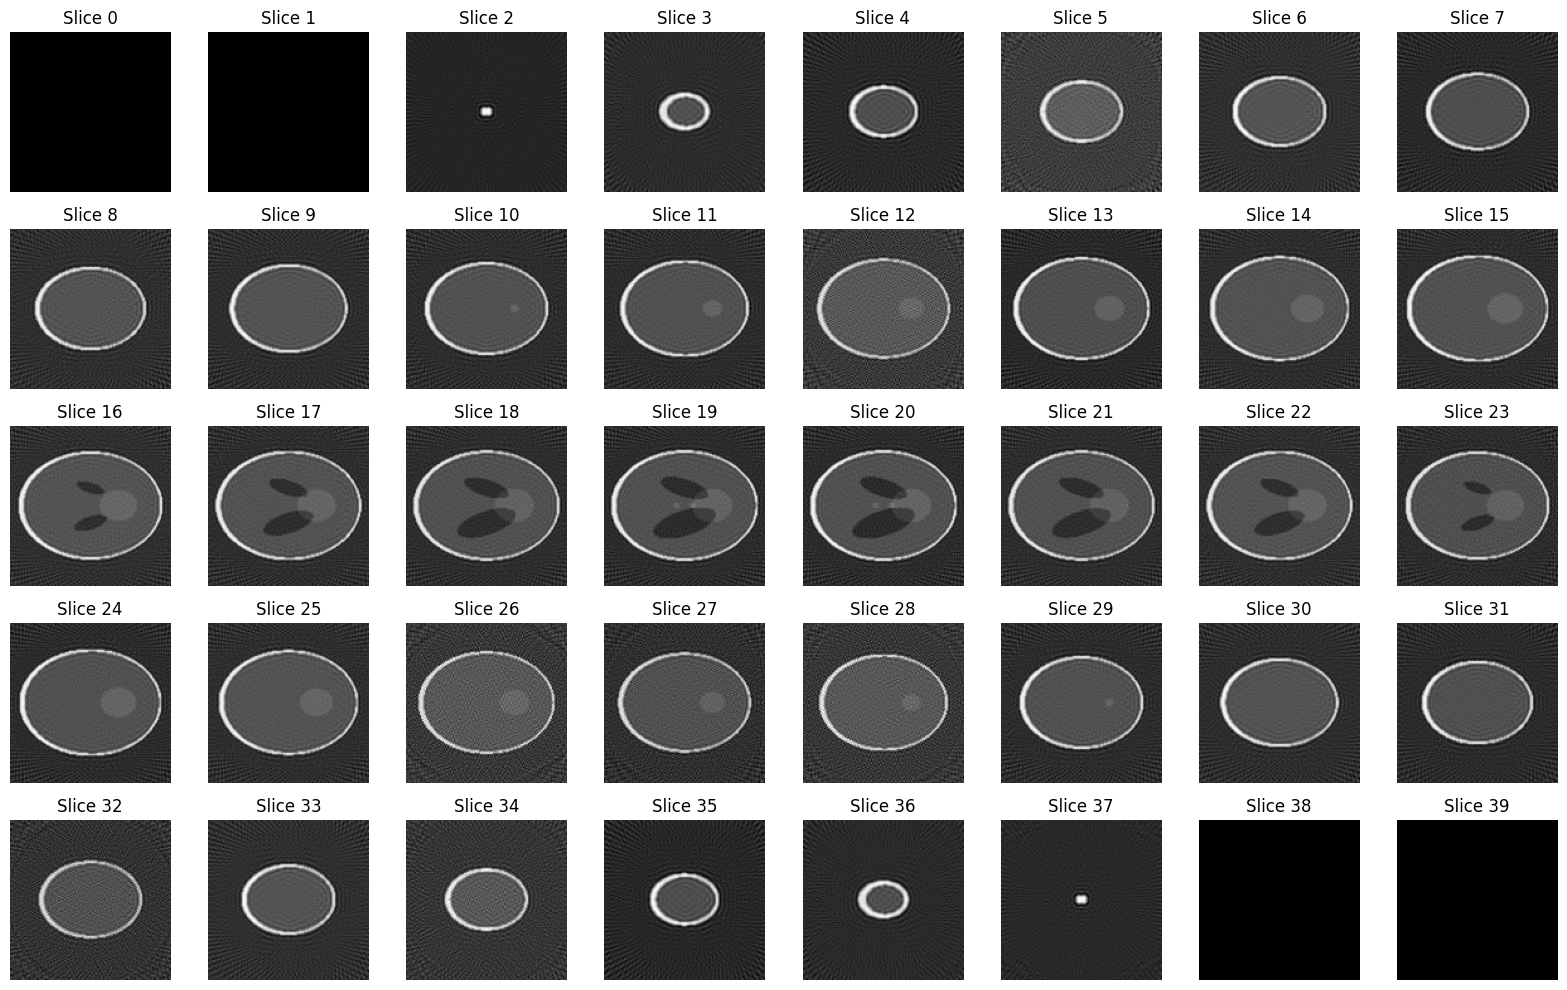

In [ ]:
# Load the saved MBIR reconstruction
mbir_reconstruction = np.load("mbir_reconstruction.npy")

# Get the middle slice of the reconstructed volume for visualization
mid_slice = mbir_reconstruction.shape[2] // 2

# Plot the middle slice
plt.figure(figsize=(10, 6))
plt.imshow(mbir_reconstruction[:, :, mid_slice], cmap="gray")
plt.title("MBIR Reconstruction (Middle Slice)")
plt.axis("off")
plt.colorbar()
plt.show()

# Plot multiple slices for inspection
num_slices = mbir_reconstruction.shape[2]
cols = 8  # Number of columns in the grid
rows = int(np.ceil(num_slices / cols))  # Compute number of rows

fig, axes = plt.subplots(rows, cols, figsize=(16, 2 * rows))
for i in range(num_slices):
    row, col = divmod(i, cols)
    axes[row, col].imshow(mbir_reconstruction[:, :, i], cmap="gray")
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Slice {i}")

# Hide unused subplots
for i in range(num_slices, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()
